## Preambule

In [1]:
import numpy as np
from tqdm import tqdm
from importlib import reload
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Run classes

In [2]:
import class_datareading
reload(class_datareading)
from class_datareading import datareading

datareader = datareading()
datareader.read_general()
datareader.read_ssps()
datareader.read_undata()
datareader.read_historicalemis()
datareader.read_ar6()
datareader.relation_budget_nonco2()
datareader.determine_global_nonco2_trajectories()
datareader.determine_global_budgets() 
datareader.determine_global_co2_trajectories()
datareader.read_baseline()   
datareader.read_ndc() 
datareader.merge_xr()
datareader.add_country_groups()
datareader.save()

# ==================================== #
# Initializing datareading class     #
# ==================================== #
- Reading general data
- Reading GDP and population data from SSPs
- Reading UN population data (for past population)
- Reading historical emissions (primap)
- Read AR6 data
- Get relationship between CO2 budgets and non-co2 reduction in 2050
- Computing global nonco2 trajectories
- Get global CO2 budgets
- Computing global co2 trajectories
- Reading baseline emissions
- Reading NDC data
- Merging xrarray object
- Add country groups
- Save important files


In [2]:
import class_allocation

reload(class_allocation)
from class_allocation import allocation

for cty in tqdm(['NLD']):#np.array(datareader.xr_total.Region)):
    allocator = allocation(cty, version='PBL')
    allocator.gf()  
    allocator.pc()
    allocator.pcc()
    allocator.pcb()
    allocator.ecpc()
    allocator.ap()
    allocator.gdr()
    #allocator.save()

100%|██████████| 1/1 [00:39<00:00, 39.73s/it]


In [3]:
self = allocator

In [4]:
# co2 part
def budget_harm(nz):
    compensation_form = np.sqrt(np.arange(0, 2101-self.settings['params']['start_year_analysis']))
    xr_comp2 =  xr.DataArray(compensation_form, dims=['Time'], coords={'Time': np.arange(self.settings['params']['start_year_analysis'], 2101)})
    return xr_comp2 / ((nz-2021)**(3/2)*(2/3)) # TODO later: should be , but I now calibrated to 0.5. Not a problem because we have the while loop later.
def pcb_new_factor(path, f):
    netzeros = 2021+path.where(path > 0, 0).where(path < 0 , 1).sum(dim='Time')
    netzeros = netzeros.where(netzeros < 2100, 2100)
    return path+budget_harm(netzeros)*f

pop_region = self.xr_total.sel(Time=self.start_year_analysis).Population
pop_earth = self.xr_total.sel(Region=self.countries_iso, 
                            Time=self.start_year_analysis).Population.sum(dim=['Region'])
pop_fraction =  (pop_region / pop_earth).mean(dim='Scenario')
globalpath = self.xr_total.CO2_globe

emis_2021_i = self.xr_total.CO2_hist.sel(Time=self.start_year_analysis)
emis_2021_w = self.xr_total.CO2_hist.sel(Time=self.start_year_analysis, 
                                            Region='EARTH')
path_scaled_0 = (emis_2021_i/emis_2021_w*globalpath).sel(Time=np.arange(self.start_year_analysis, 2101)).sel(Region=self.FocusRegion)
budget_left = (self.xr_total.CO2_globe.where(self.xr_total.CO2_globe > 0, 0).sel(Time=np.arange(self.start_year_analysis, 2101)).sum(dim='Time')*pop_fraction).sel(Region=self.FocusRegion)

budget_without_assumptions_prepeak = path_scaled_0.where(path_scaled_0 > 0, 0).sum(dim='Time')
budget_surplus = (budget_left - budget_without_assumptions_prepeak)
pcb = pcb_new_factor(path_scaled_0, budget_surplus).to_dataset(name='PCB')

# Optimize to bend the CO2 curves as close as possible to the CO2 budgets
it=0
while it < 3:
    pcb_pos = pcb.where(pcb > 0, 0).sum(dim='Time')
    budget_surplus = (budget_left - pcb_pos).PCB
    pcb = pcb_new_factor(pcb.PCB, budget_surplus).to_dataset(name='PCB')
    it+=1

# CO2, but now linear
nz = (budget_left*2/self.xr_total.CO2_hist.sel(Region=self.FocusRegion, Time=self.start_year_analysis)+self.start_year_analysis-1)
coef = self.xr_total.CO2_hist.sel(Region=self.FocusRegion, Time=self.start_year_analysis)/(nz-self.start_year_analysis)
linear_co2 = -coef*xr.DataArray(np.arange(0, 2101-self.start_year_analysis), dims=['Time'], coords={'Time': np.arange(self.settings['params']['start_year_analysis'], 2101)})+self.xr_total.CO2_hist.sel(Region=self.FocusRegion, Time=self.start_year_analysis)
linear_co2_pos = linear_co2.where(linear_co2 > 0, 0).to_dataset(name='PCB_lin')

In [15]:
self.xr_total.CO2_globe.where(self.xr_total.CO2_globe > 0, 0).sel(Time=np.arange(self.start_year_analysis, 2101)).sum(dim='Time').sel(Temperature=1.56, Risk=0.5, NonCO2red=0.5, NegEmis=0.5, Timing='Immediate')

<xarray.DataArray 'CO2_globe' ()>
array(487543.35025635)
Coordinates:
    Temperature  float64 1.56
    Risk         float64 0.5
    NonCO2red    float64 0.5
    NegEmis      float64 0.5
    Timing       <U9 'Immediate'
    source       <U25 'PRIMAP-hist_v2.5_final_nr'
    Version      <U6 'HISTTP'
    variable     <U8 'CO2_base'

In [19]:
self.xr_total.Budget.sel(Temperature=1.56, Risk=0.5, NonCO2red=0.33)

<xarray.DataArray 'Budget' ()>
array(448.28335026)
Coordinates:
    Temperature  float64 1.56
    Risk         float64 0.5
    NonCO2red    float64 0.33
    source       <U25 'PRIMAP-hist_v2.5_final_nr'
    Version      <U6 'HISTTP'
    variable     <U8 'CO2_base'

In [9]:
linear_co2_pos.sel(Temperature=1.56, Risk=0.5, NonCO2red=0.5, NegEmis=0.3, Timing='Immediate').PCB_lin.sum()

<xarray.DataArray 'PCB_lin' ()>
array(1086.83809642)
Coordinates:
    Region       <U16 'NLD'
    source       <U25 'PRIMAP-hist_v2.5_final_nr'
    Version      <U6 'HISTTP'
    variable     <U8 'CO2_base'
    Temperature  float64 1.56
    Risk         float64 0.5
    NonCO2red    float64 0.5
    NegEmis      float64 0.3
    Timing       <U9 'Immediate'

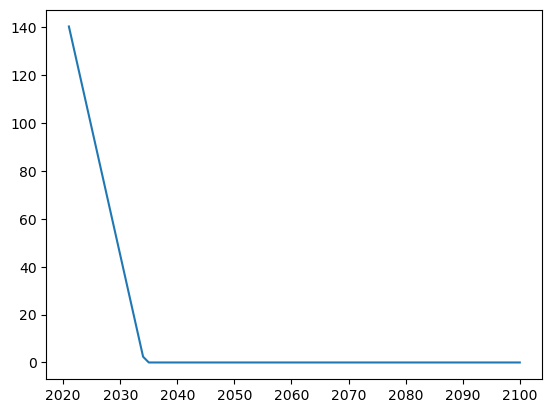

In [20]:
plt.plot(linear_co2_pos.Time, linear_co2_pos.sel(Temperature=1.56, Risk=0.5, NonCO2red=0.33, NegEmis=0.3, Timing='Immediate').PCB_lin)

In [6]:
import class_tempalign
reload(class_tempalign)
from class_tempalign import tempaligning

tempaligner = tempaligning() # FIRST RUN AGGREGATOR FOR THIS!! (2030 alloc)
tempaligner.get_relation_2030emis_temp()
tempaligner.determine_tempoutcomes()
tempaligner.save()

# ==================================== #
# Initializing tempaligning class        #
# ==================================== #
- Determine relation between 2030-emissions and temperature outcome
- Determine temperature metric


100%|██████████| 6/6 [00:53<00:00,  8.99s/it]


- Save


In [2]:
import class_policyscens
reload(class_policyscens)
from class_policyscens import policyscenadding

policyscenner = policyscenadding()
policyscenner.read_engage_data()
policyscenner.filter_and_convert()
policyscenner.add_to_xr()

# ==================================== #
# Initializing policyscenadding class  #
# ==================================== #
- Read ENGAGE scenarios and change region namings
- Filter correct scenarios and convert to xarray object
- Add to overall xrobject
